In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pprint import pprint
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

Using TensorFlow backend.


In [3]:
start = datetime(2000,1,1)
end = datetime(2016,1,1)

In [4]:
# original_data = pdr.get_data_yahoo('SPY', start, end)
# original_data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

In [5]:
# original_data.to_pickle('SPY.pkl')

In [6]:
original_data = pd.read_pickle('SPY.pkl')

In [7]:
original_data.head()

,Open,High,Low,Close
Date,,,,
1999-12-31,146.843704,147.500000,146.250000,146.8750
2000-01-03,148.250000,148.250000,143.875000,145.4375
2000-01-04,143.531204,144.062500,139.640594,139.7500
2000-01-05,139.937500,141.531204,137.250000,140.0000
2000-01-06,139.625000,141.500000,137.750000,137.7500


### Create data representation

In [8]:
max_shift = 10

In [9]:
data = original_data.copy()
data.columns = pd.MultiIndex.from_product([['Shift 0'],['Open','High','Low','Close']])
for i in range(1, max_shift + 1):
    shifted = data.iloc[:,[0,1,2,3]].shift(i)
    shifted.columns = pd.MultiIndex.from_product([['Shift ' + str(i)],['Open','High','Low','Close']])
    data = pd.concat([data, shifted], axis=1)

In [10]:
data.head(6)

Shift 0                                       Shift 1  \
                  Open        High         Low     Close        Open   
Date                                                                   
1999-12-31  146.843704  147.500000  146.250000  146.8750         NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375  146.843704   
2000-01-04  143.531204  144.062500  139.640594  139.7500  148.250000   
2000-01-05  139.937500  141.531204  137.250000  140.0000  143.531204   
2000-01-06  139.625000  141.500000  137.750000  137.7500  139.937500   
2000-01-07  140.312500  145.750000  140.062500  145.7500  139.625000   

                                                 Shift 2              ...   \
                  High         Low     Close        Open        High  ...    
Date                                                                  ...    
1999-12-31         NaN         NaN       NaN         NaN         NaN  ...    
2000-01-03  147.500000  146.250000  146.8750         NaN         NaN  ...    
2000-01-04  148.250000  143.875000  145.4375  146.843704  147.500000  ...    
2000-01-05  144.062500  139.640594  139.7500  148.250000  148.250000  ...    
2000-01-06  141.531204  137.250000  140.0000  143.531204  144.062500  ...    
2000-01-07  141.500000  137.750000  137.7500  139.937500  141.531204  ...    

           Shift 8       Shift 9                Shift 10                 
               Low Close    Open High Low Close     Open High Low Close  
Date                                                                     
1999-12-31     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-03     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-04     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-05     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-06     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-07     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  

[6 rows x 44 columns]

In [11]:
data['Shift 2', 'Close'].head(3)

Date
1999-12-31        NaN
2000-01-03        NaN
2000-01-04    146.875
Name: (Shift 2, Close), dtype: float64

In [12]:
for i in range(0, max_shift):
    cls = data['Shift ' + str(i), 'Close']
    opn = data['Shift ' + str(i), 'Open']
    data['Shift ' + str(i), 'Bull ' + str(i)] = 100 * (cls - opn) / cls

In [13]:
data['Shift 0'].head(2)

,Open,High,Low,Close,Bull 0
Date,,,,,
1999-12-31,146.843704,147.50,146.250,146.8750,0.021308
2000-01-03,148.250000,148.25,143.875,145.4375,-1.933820


In [14]:
for i in range(0, max_shift):
    opn = data['Shift ' + str(i), 'Open']
    prv_cls = data['Shift ' + str(i+1), 'Close']
    data['Shift ' + str(i), 'GT ' + str(i)] = 100 * (opn - prv_cls) / opn

In [15]:
data[['Shift 0', 'Shift 1']].head()

Shift 0                                                        \
                  Open        High         Low     Close    Bull 0      GT 0   
Date                                                                           
1999-12-31  146.843704  147.500000  146.250000  146.8750  0.021308       NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375 -1.933820  0.927487   
2000-01-04  143.531204  144.062500  139.640594  139.7500 -2.705692 -1.328140   
2000-01-05  139.937500  141.531204  137.250000  140.0000  0.044643  0.133988   
2000-01-06  139.625000  141.500000  137.750000  137.7500 -1.361162 -0.268577   

               Shift 1                                                        
                  Open        High         Low     Close    Bull 1      GT 1  
Date                                                                          
1999-12-31         NaN         NaN         NaN       NaN       NaN       NaN  
2000-01-03  146.843704  147.500000  146.250000  146.8750  0.021308       NaN  
2000-01-04  148.250000  148.250000  143.875000  145.4375 -1.933820  0.927487  
2000-01-05  143.531204  144.062500  139.640594  139.7500 -2.705692 -1.328140  
2000-01-06  139.937500  141.531204  137.250000  140.0000  0.044643  0.133988

In [16]:
shifted = data.iloc[:,[0,1,2,3]].shift(-5)
shifted.columns = pd.MultiIndex.from_product([['Shift -5'],['Open','High','Low','Close']])
data = pd.concat([data, shifted], axis=1)

In [17]:
cls_5 = data['Shift -5', 'Close']
cls = data['Shift 0', 'Close']
data['Shift 0', 'Return'] = 100 * (cls_5 - cls) / cls_5
data.head()

Shift 0                                       Shift 1  \
                  Open        High         Low     Close        Open   
Date                                                                   
1999-12-31  146.843704  147.500000  146.250000  146.8750         NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375  146.843704   
2000-01-04  143.531204  144.062500  139.640594  139.7500  148.250000   
2000-01-05  139.937500  141.531204  137.250000  140.0000  143.531204   
2000-01-06  139.625000  141.500000  137.750000  137.7500  139.937500   

                                                 Shift 2              ...     \
                  High         Low     Close        Open      High    ...      
Date                                                                  ...      
1999-12-31         NaN         NaN       NaN         NaN       NaN    ...      
2000-01-03  147.500000  146.250000  146.8750         NaN       NaN    ...      
2000-01-04  148.250000  143.875000  145.4375  146.843704  147.5000    ...      
2000-01-05  144.062500  139.640594  139.7500  148.250000  148.2500    ...      
2000-01-06  141.531204  137.250000  140.0000  143.531204  144.0625    ...      

           Shift 5 Shift 6 Shift 7 Shift 8 Shift 9    Shift -5              \
              GT 5    GT 6    GT 7    GT 8    GT 9        Open        High   
Date                                                                         
1999-12-31     NaN     NaN     NaN     NaN     NaN  140.312500  145.750000   
2000-01-03     NaN     NaN     NaN     NaN     NaN  146.250000  146.906204   
2000-01-04     NaN     NaN     NaN     NaN     NaN  145.812500  146.093704   
2000-01-05     NaN     NaN     NaN     NaN     NaN  144.593704  144.593704   
2000-01-06     NaN     NaN     NaN     NaN     NaN  144.468704  145.750000   

                                   Shift 0  
                   Low     Close    Return  
Date                                        
1999-12-31  140.062500  145.7500 -0.771870  
2000-01-03  145.031204  146.2500  0.555556  
2000-01-04  143.500000  144.5000  3.287197  
2000-01-05  142.875000  143.0625  2.140673  
2000-01-06  143.281204  145.0000  5.000000  

[5 rows x 69 columns]

In [18]:
binary_data = data.drop(['Open', 'High', 'Low', 'Close'], axis=1, level=1)
binary_data.head()

,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 6,Shift 7,Shift 8,Shift 9,...,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 6,Shift 7,Shift 8,Shift 9,Shift 0
,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 1,GT 2,GT 3,GT 4,GT 5,GT 6,GT 7,GT 8,GT 9,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.771870
2000-01-03,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555556
2000-01-04,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.287197
2000-01-05,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.140673
2000-01-06,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,...,0.133988,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,5.000000


In [19]:
binary_data.columns = binary_data.columns.droplevel()

In [20]:
binary_data.head(10)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 1,GT 2,GT 3,GT 4,GT 5,GT 6,GT 7,GT 8,GT 9,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.771870
2000-01-03,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555556
2000-01-04,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.287197
2000-01-05,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.140673
2000-01-06,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,...,0.133988,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
2000-01-07,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,...,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,0.829227
2000-01-10,0.000000,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,...,1.826281,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,NaN,NaN,-0.300043
2000-01-11,-0.908304,0.000000,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,...,0.341880,1.826281,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,NaN,1.700680
2000-01-12,-1.070304,-0.908304,0.000000,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,...,-0.300043,0.341880,1.826281,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,1.165803


### Explore data

In [21]:
binary_data.sort_values('Return', ascending=False).head(5)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 1,GT 2,GT 3,GT 4,GT 5,GT 6,GT 7,GT 8,GT 9,Return
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-20,-6.202784,-5.411048,2.216353,-1.064696,-3.220966,5.528135,-2.808207,-1.102824,-2.785277,2.354570,...,-1.361888,-0.375806,-0.277849,-1.968453,0.359918,-1.745431,-2.060373,1.417916,0.861976,16.250416
2008-10-27,-2.406199,3.423717,1.526885,-2.824358,-1.157939,3.501670,1.308874,2.644765,-8.264833,-4.857285,...,-9.076855,-0.387638,-2.854082,-1.897491,2.244362,-1.934992,1.391175,-2.452287,3.199617,13.551646
2002-07-23,-3.252040,-2.311437,-2.420025,-3.302954,-1.895527,-0.618380,0.758065,-1.611327,1.195220,-4.211894,...,-0.725328,-1.198710,-0.044103,2.054944,-1.338886,-0.229156,0.492874,-0.392329,0.416669,12.084896
2009-03-09,0.234920,-0.696465,-1.889528,0.697058,-2.197804,-2.719545,-0.108213,-2.909279,-0.351237,2.826538,...,0.864552,-2.325257,1.628531,1.410422,-1.944295,-2.175383,1.220762,-0.440762,0.850045,10.216188
2008-10-24,3.423717,1.526885,-2.824358,-1.157939,3.501670,1.308874,2.644765,-8.264833,-4.857285,7.380360,...,-0.387638,-2.854082,-1.897491,2.244362,-1.934992,1.391175,-2.452287,3.199617,5.720681,10.110504


# Train Keras NN

### Setup X_train, X_test, etc

In [22]:
binary_data.dropna(inplace=True)

In [23]:
scaler = StandardScaler()
scaled_values = scaler.fit_transform(binary_data)

In [24]:
binary_data = pd.DataFrame(scaled_values, index=binary_data.index, columns=binary_data.columns)

In [25]:
binary_data.head()

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 1,GT 2,GT 3,GT 4,GT 5,GT 6,GT 7,GT 8,GT 9,Return
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-14,0.293536,0.358720,-1.001864,-0.848095,0.011873,3.540434,-1.276637,0.053341,-2.545856,-1.815280,...,1.389765,0.074994,-0.452764,0.476056,2.622468,-0.407767,0.174957,-1.939402,1.322558,-1.811315
2000-01-18,0.316104,0.293611,0.359024,-1.001531,-0.848596,0.010571,3.540482,-1.276614,0.054033,-2.544670,...,1.493398,1.390020,0.075359,-0.453375,0.475056,2.623022,-0.407576,0.175388,-1.940553,-1.049054
2000-01-19,1.098997,0.316180,0.293923,0.359238,-1.002064,-0.848835,0.011079,3.540520,-1.274873,0.054298,...,-1.637084,1.493660,1.390508,0.074883,-0.453584,0.475428,2.623794,-0.406873,0.174640,-1.686314
2000-01-20,-1.440452,1.099099,0.316489,0.294142,0.358988,-1.002114,-0.848215,0.011106,3.538461,-1.274137,...,-0.516955,-1.637028,1.494158,1.390369,0.074224,-0.453291,0.475788,2.623081,-0.407732,-1.232290
2000-01-21,-0.685297,-1.440433,1.099324,0.316707,0.293879,0.357257,-1.001474,-0.848191,0.011832,3.537493,...,-0.049784,-0.516825,-1.636825,1.494046,1.388591,0.074562,-0.453109,0.476078,2.622800,-2.416839


In [26]:
X = binary_data.drop('Return', axis=1)

In [27]:
y = binary_data['Return'] > 0

In [28]:
y[0:10]

Date
2000-01-14    False
2000-01-18    False
2000-01-19    False
2000-01-20    False
2000-01-21    False
2000-01-24    False
2000-01-25    False
2000-01-26     True
2000-01-27     True
2000-01-28     True
Name: Return, dtype: bool

In [29]:
y = np.expand_dims(y, axis=1)

In [30]:
y = np.hstack((y, 1 - y))

In [31]:
y[0:10]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0]])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Build model

In [40]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(80, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(80, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(50, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(25, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(2, kernel_initializer='uniform'))
model.add(Activation('softmax'))

model.compile(optimizer=Adam(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
model.fit(X_train.values, y_train, 
          validation_data=(X_test.values, y_test),
          epochs=3000, 
          batch_size=256, 
          verbose=2)

Train on 3208 samples, validate on 803 samples
Epoch 1/3000
1s - loss: 0.6927 - acc: 0.5181 - val_loss: 0.6884 - val_acc: 0.6015
Epoch 2/3000
0s - loss: 0.6923 - acc: 0.5293 - val_loss: 0.6882 - val_acc: 0.6015
Epoch 3/3000
0s - loss: 0.6882 - acc: 0.5421 - val_loss: 0.6849 - val_acc: 0.6015
Epoch 4/3000
0s - loss: 0.6881 - acc: 0.5561 - val_loss: 0.6828 - val_acc: 0.6015
Epoch 5/3000
0s - loss: 0.6873 - acc: 0.5468 - val_loss: 0.6823 - val_acc: 0.6015
Epoch 6/3000
0s - loss: 0.6848 - acc: 0.5567 - val_loss: 0.6835 - val_acc: 0.6015
Epoch 7/3000
0s - loss: 0.6761 - acc: 0.5770 - val_loss: 0.6812 - val_acc: 0.6015
Epoch 8/3000
0s - loss: 0.6773 - acc: 0.5804 - val_loss: 0.6819 - val_acc: 0.5990
Epoch 9/3000
0s - loss: 0.6698 - acc: 0.5892 - val_loss: 0.6820 - val_acc: 0.5940
Epoch 10/3000
0s - loss: 0.6685 - acc: 0.5963 - val_loss: 0.6834 - val_acc: 0.5741
Epoch 11/3000
0s - loss: 0.6667 - acc: 0.5926 - val_loss: 0.6836 - val_acc: 0.5641
Epoch 12/3000
0s - loss: 0.6617 - acc: 0.6103 - v

0s - loss: 0.4230 - acc: 0.7996 - val_loss: 0.9165 - val_acc: 0.5629
Epoch 101/3000
0s - loss: 0.4453 - acc: 0.7837 - val_loss: 0.8609 - val_acc: 0.5679
Epoch 102/3000
0s - loss: 0.4247 - acc: 0.8127 - val_loss: 0.8953 - val_acc: 0.5616
Epoch 103/3000
0s - loss: 0.4222 - acc: 0.8005 - val_loss: 0.9190 - val_acc: 0.5616
Epoch 104/3000
0s - loss: 0.4197 - acc: 0.7946 - val_loss: 1.0007 - val_acc: 0.5430
Epoch 105/3000
0s - loss: 0.4273 - acc: 0.8064 - val_loss: 0.8919 - val_acc: 0.5479
Epoch 106/3000
0s - loss: 0.4132 - acc: 0.8120 - val_loss: 0.9516 - val_acc: 0.5255
Epoch 107/3000
0s - loss: 0.4213 - acc: 0.8017 - val_loss: 0.9043 - val_acc: 0.5517
Epoch 108/3000
0s - loss: 0.4087 - acc: 0.8092 - val_loss: 0.9292 - val_acc: 0.5479
Epoch 109/3000
0s - loss: 0.4191 - acc: 0.8105 - val_loss: 0.9124 - val_acc: 0.5542
Epoch 110/3000
0s - loss: 0.4364 - acc: 0.7974 - val_loss: 0.8832 - val_acc: 0.5455
Epoch 111/3000
0s - loss: 0.4107 - acc: 0.8108 - val_loss: 0.9024 - val_acc: 0.5479
Epoch 1

0s - loss: 0.3553 - acc: 0.8416 - val_loss: 1.0185 - val_acc: 0.5417
Epoch 199/3000
0s - loss: 0.3716 - acc: 0.8335 - val_loss: 1.0076 - val_acc: 0.5529
Epoch 200/3000
0s - loss: 0.3484 - acc: 0.8420 - val_loss: 1.0309 - val_acc: 0.5691
Epoch 201/3000
0s - loss: 0.3664 - acc: 0.8392 - val_loss: 1.0602 - val_acc: 0.5467
Epoch 202/3000
0s - loss: 0.3694 - acc: 0.8388 - val_loss: 0.9758 - val_acc: 0.5367
Epoch 203/3000
0s - loss: 0.3650 - acc: 0.8332 - val_loss: 0.9872 - val_acc: 0.5392
Epoch 204/3000
0s - loss: 0.3531 - acc: 0.8423 - val_loss: 0.9842 - val_acc: 0.5367
Epoch 205/3000
0s - loss: 0.3670 - acc: 0.8320 - val_loss: 1.0102 - val_acc: 0.5380
Epoch 206/3000
0s - loss: 0.3434 - acc: 0.8485 - val_loss: 1.0444 - val_acc: 0.5455
Epoch 207/3000
0s - loss: 0.3661 - acc: 0.8410 - val_loss: 1.0271 - val_acc: 0.5554
Epoch 208/3000
0s - loss: 0.3541 - acc: 0.8339 - val_loss: 1.0790 - val_acc: 0.5417
Epoch 209/3000
0s - loss: 0.3632 - acc: 0.8351 - val_loss: 1.0348 - val_acc: 0.5342
Epoch 2

0s - loss: 0.3386 - acc: 0.8519 - val_loss: 1.0465 - val_acc: 0.5380
Epoch 298/3000
0s - loss: 0.3481 - acc: 0.8519 - val_loss: 1.0736 - val_acc: 0.5230
Epoch 299/3000
0s - loss: 0.3349 - acc: 0.8588 - val_loss: 1.0055 - val_acc: 0.5305
Epoch 300/3000
0s - loss: 0.3573 - acc: 0.8410 - val_loss: 0.9834 - val_acc: 0.5230
Epoch 301/3000
0s - loss: 0.3538 - acc: 0.8501 - val_loss: 0.9980 - val_acc: 0.5293
Epoch 302/3000
0s - loss: 0.3373 - acc: 0.8466 - val_loss: 1.0386 - val_acc: 0.5430
Epoch 303/3000
0s - loss: 0.3451 - acc: 0.8466 - val_loss: 1.0297 - val_acc: 0.5330
Epoch 304/3000
0s - loss: 0.3299 - acc: 0.8491 - val_loss: 1.0677 - val_acc: 0.5380
Epoch 305/3000
0s - loss: 0.3286 - acc: 0.8572 - val_loss: 1.0999 - val_acc: 0.5380
Epoch 306/3000
0s - loss: 0.3265 - acc: 0.8613 - val_loss: 1.1063 - val_acc: 0.5367
Epoch 307/3000
0s - loss: 0.3486 - acc: 0.8482 - val_loss: 1.0617 - val_acc: 0.5392
Epoch 308/3000
0s - loss: 0.3351 - acc: 0.8535 - val_loss: 1.0478 - val_acc: 0.5455
Epoch 3

0s - loss: 0.3214 - acc: 0.8632 - val_loss: 1.0509 - val_acc: 0.5330
Epoch 397/3000
0s - loss: 0.3432 - acc: 0.8491 - val_loss: 1.0159 - val_acc: 0.5156
Epoch 398/3000
0s - loss: 0.3111 - acc: 0.8697 - val_loss: 1.0488 - val_acc: 0.5230
Epoch 399/3000
0s - loss: 0.3213 - acc: 0.8554 - val_loss: 1.1077 - val_acc: 0.5193
Epoch 400/3000
0s - loss: 0.3283 - acc: 0.8575 - val_loss: 1.1021 - val_acc: 0.5218
Epoch 401/3000
0s - loss: 0.3342 - acc: 0.8538 - val_loss: 1.0555 - val_acc: 0.5068
Epoch 402/3000
0s - loss: 0.3260 - acc: 0.8610 - val_loss: 1.0792 - val_acc: 0.5106
Epoch 403/3000
0s - loss: 0.3145 - acc: 0.8663 - val_loss: 1.1070 - val_acc: 0.5168
Epoch 404/3000
0s - loss: 0.3475 - acc: 0.8507 - val_loss: 1.0709 - val_acc: 0.5367
Epoch 405/3000
0s - loss: 0.3190 - acc: 0.8656 - val_loss: 1.0422 - val_acc: 0.5330
Epoch 406/3000
0s - loss: 0.3123 - acc: 0.8622 - val_loss: 1.1063 - val_acc: 0.5243
Epoch 407/3000
0s - loss: 0.3331 - acc: 0.8585 - val_loss: 1.0852 - val_acc: 0.5405
Epoch 4

0s - loss: 0.3157 - acc: 0.8638 - val_loss: 1.0504 - val_acc: 0.5342
Epoch 496/3000
0s - loss: 0.3098 - acc: 0.8653 - val_loss: 1.1037 - val_acc: 0.5218
Epoch 497/3000
0s - loss: 0.3088 - acc: 0.8716 - val_loss: 1.0632 - val_acc: 0.5417
Epoch 498/3000
0s - loss: 0.3050 - acc: 0.8641 - val_loss: 1.0394 - val_acc: 0.5318
Epoch 499/3000
0s - loss: 0.3246 - acc: 0.8557 - val_loss: 1.0065 - val_acc: 0.5405
Epoch 500/3000
0s - loss: 0.3122 - acc: 0.8625 - val_loss: 1.0518 - val_acc: 0.5305
Epoch 501/3000
0s - loss: 0.2964 - acc: 0.8703 - val_loss: 1.0738 - val_acc: 0.5330
Epoch 502/3000
0s - loss: 0.3095 - acc: 0.8719 - val_loss: 1.0785 - val_acc: 0.5330
Epoch 503/3000
0s - loss: 0.3048 - acc: 0.8669 - val_loss: 1.1034 - val_acc: 0.5305
Epoch 504/3000
0s - loss: 0.2886 - acc: 0.8762 - val_loss: 1.1078 - val_acc: 0.5392
Epoch 505/3000
0s - loss: 0.3287 - acc: 0.8644 - val_loss: 1.0372 - val_acc: 0.5305
Epoch 506/3000
0s - loss: 0.3130 - acc: 0.8619 - val_loss: 1.0043 - val_acc: 0.5342
Epoch 5

0s - loss: 0.2985 - acc: 0.8703 - val_loss: 1.1199 - val_acc: 0.5293
Epoch 594/3000
0s - loss: 0.2867 - acc: 0.8762 - val_loss: 1.1561 - val_acc: 0.5255
Epoch 595/3000
0s - loss: 0.3220 - acc: 0.8666 - val_loss: 1.1032 - val_acc: 0.5205
Epoch 596/3000
0s - loss: 0.3331 - acc: 0.8579 - val_loss: 1.0017 - val_acc: 0.5293
Epoch 597/3000
0s - loss: 0.3179 - acc: 0.8613 - val_loss: 1.0415 - val_acc: 0.5255
Epoch 598/3000
0s - loss: 0.3069 - acc: 0.8719 - val_loss: 1.1032 - val_acc: 0.5255
Epoch 599/3000
0s - loss: 0.2926 - acc: 0.8744 - val_loss: 1.1023 - val_acc: 0.5230
Epoch 600/3000
0s - loss: 0.3136 - acc: 0.8610 - val_loss: 1.1003 - val_acc: 0.5181
Epoch 601/3000
0s - loss: 0.2947 - acc: 0.8731 - val_loss: 1.1542 - val_acc: 0.5106
Epoch 602/3000
0s - loss: 0.3170 - acc: 0.8644 - val_loss: 1.0999 - val_acc: 0.5230
Epoch 603/3000
0s - loss: 0.3070 - acc: 0.8666 - val_loss: 1.0694 - val_acc: 0.5305
Epoch 604/3000
0s - loss: 0.3017 - acc: 0.8744 - val_loss: 1.1292 - val_acc: 0.5330
Epoch 6

0s - loss: 0.2931 - acc: 0.8775 - val_loss: 1.1068 - val_acc: 0.5181
Epoch 692/3000
0s - loss: 0.3009 - acc: 0.8681 - val_loss: 1.0892 - val_acc: 0.5143
Epoch 693/3000
0s - loss: 0.3009 - acc: 0.8756 - val_loss: 1.0818 - val_acc: 0.5156
Epoch 694/3000
0s - loss: 0.3101 - acc: 0.8660 - val_loss: 1.0795 - val_acc: 0.5143
Epoch 695/3000
0s - loss: 0.2805 - acc: 0.8809 - val_loss: 1.1341 - val_acc: 0.5268
Epoch 696/3000
0s - loss: 0.2945 - acc: 0.8784 - val_loss: 1.1140 - val_acc: 0.5218
Epoch 697/3000
0s - loss: 0.3180 - acc: 0.8635 - val_loss: 1.0842 - val_acc: 0.5168
Epoch 698/3000
0s - loss: 0.2905 - acc: 0.8778 - val_loss: 1.1119 - val_acc: 0.5205
Epoch 699/3000
0s - loss: 0.2924 - acc: 0.8794 - val_loss: 1.0951 - val_acc: 0.5367
Epoch 700/3000
0s - loss: 0.3303 - acc: 0.8588 - val_loss: 1.0478 - val_acc: 0.5355
Epoch 701/3000
0s - loss: 0.3098 - acc: 0.8622 - val_loss: 1.0585 - val_acc: 0.5293
Epoch 702/3000
0s - loss: 0.2967 - acc: 0.8719 - val_loss: 1.1441 - val_acc: 0.5156
Epoch 7

0s - loss: 0.2892 - acc: 0.8794 - val_loss: 1.1146 - val_acc: 0.5380
Epoch 790/3000
0s - loss: 0.3037 - acc: 0.8753 - val_loss: 1.0539 - val_acc: 0.5380
Epoch 791/3000
0s - loss: 0.2983 - acc: 0.8734 - val_loss: 1.0413 - val_acc: 0.5255
Epoch 792/3000
0s - loss: 0.3222 - acc: 0.8616 - val_loss: 1.0218 - val_acc: 0.5342
Epoch 793/3000
0s - loss: 0.2904 - acc: 0.8822 - val_loss: 1.0560 - val_acc: 0.5330
Epoch 794/3000
0s - loss: 0.3045 - acc: 0.8669 - val_loss: 1.0434 - val_acc: 0.5243
Epoch 795/3000
0s - loss: 0.3028 - acc: 0.8728 - val_loss: 1.0441 - val_acc: 0.5168
Epoch 796/3000
0s - loss: 0.2897 - acc: 0.8766 - val_loss: 1.0672 - val_acc: 0.5342
Epoch 797/3000
0s - loss: 0.3030 - acc: 0.8691 - val_loss: 1.1212 - val_acc: 0.5342
Epoch 798/3000
0s - loss: 0.2877 - acc: 0.8772 - val_loss: 1.1229 - val_acc: 0.5417
Epoch 799/3000
0s - loss: 0.3052 - acc: 0.8716 - val_loss: 1.0585 - val_acc: 0.5293
Epoch 800/3000
0s - loss: 0.3039 - acc: 0.8728 - val_loss: 1.0470 - val_acc: 0.5392
Epoch 8

0s - loss: 0.2877 - acc: 0.8781 - val_loss: 1.1053 - val_acc: 0.5131
Epoch 889/3000
0s - loss: 0.2966 - acc: 0.8747 - val_loss: 1.1000 - val_acc: 0.5168
Epoch 890/3000
0s - loss: 0.3032 - acc: 0.8762 - val_loss: 1.0739 - val_acc: 0.5243
Epoch 891/3000
0s - loss: 0.3073 - acc: 0.8694 - val_loss: 1.0652 - val_acc: 0.5168
Epoch 892/3000
0s - loss: 0.2913 - acc: 0.8787 - val_loss: 1.0896 - val_acc: 0.5218
Epoch 893/3000
0s - loss: 0.3164 - acc: 0.8641 - val_loss: 1.1025 - val_acc: 0.5143
Epoch 894/3000
0s - loss: 0.2936 - acc: 0.8815 - val_loss: 1.1029 - val_acc: 0.5168
Epoch 895/3000
0s - loss: 0.2862 - acc: 0.8766 - val_loss: 1.1477 - val_acc: 0.5118
Epoch 896/3000
0s - loss: 0.3203 - acc: 0.8600 - val_loss: 1.0755 - val_acc: 0.5031
Epoch 897/3000
0s - loss: 0.2900 - acc: 0.8703 - val_loss: 1.1278 - val_acc: 0.5168
Epoch 898/3000
0s - loss: 0.2902 - acc: 0.8719 - val_loss: 1.1750 - val_acc: 0.5268
Epoch 899/3000
0s - loss: 0.2961 - acc: 0.8825 - val_loss: 1.1125 - val_acc: 0.5293
Epoch 9

0s - loss: 0.2872 - acc: 0.8784 - val_loss: 1.1084 - val_acc: 0.5392
Epoch 987/3000
0s - loss: 0.3044 - acc: 0.8703 - val_loss: 1.0701 - val_acc: 0.5355
Epoch 988/3000
0s - loss: 0.2952 - acc: 0.8685 - val_loss: 1.0704 - val_acc: 0.5342
Epoch 989/3000
0s - loss: 0.2919 - acc: 0.8762 - val_loss: 1.1239 - val_acc: 0.5230
Epoch 990/3000
0s - loss: 0.2903 - acc: 0.8747 - val_loss: 1.1042 - val_acc: 0.5330
Epoch 991/3000
0s - loss: 0.2917 - acc: 0.8778 - val_loss: 1.0942 - val_acc: 0.5417
Epoch 992/3000
0s - loss: 0.2915 - acc: 0.8738 - val_loss: 1.1461 - val_acc: 0.5405
Epoch 993/3000
0s - loss: 0.2978 - acc: 0.8688 - val_loss: 1.1699 - val_acc: 0.5268
Epoch 994/3000
0s - loss: 0.2872 - acc: 0.8791 - val_loss: 1.1403 - val_acc: 0.5280
Epoch 995/3000
0s - loss: 0.2849 - acc: 0.8897 - val_loss: 1.1350 - val_acc: 0.5168
Epoch 996/3000
0s - loss: 0.2915 - acc: 0.8815 - val_loss: 1.1175 - val_acc: 0.5479
Epoch 997/3000
0s - loss: 0.3014 - acc: 0.8672 - val_loss: 1.0945 - val_acc: 0.5517
Epoch 9

0s - loss: 0.3047 - acc: 0.8772 - val_loss: 1.0465 - val_acc: 0.5318
Epoch 1085/3000
0s - loss: 0.2825 - acc: 0.8781 - val_loss: 1.0746 - val_acc: 0.5268
Epoch 1086/3000
0s - loss: 0.2854 - acc: 0.8750 - val_loss: 1.1340 - val_acc: 0.5243
Epoch 1087/3000
0s - loss: 0.2782 - acc: 0.8822 - val_loss: 1.1038 - val_acc: 0.5193
Epoch 1088/3000
0s - loss: 0.2895 - acc: 0.8728 - val_loss: 1.1159 - val_acc: 0.5268
Epoch 1089/3000
0s - loss: 0.2922 - acc: 0.8728 - val_loss: 1.0770 - val_acc: 0.5168
Epoch 1090/3000
0s - loss: 0.2857 - acc: 0.8803 - val_loss: 1.0743 - val_acc: 0.5243
Epoch 1091/3000
0s - loss: 0.3016 - acc: 0.8738 - val_loss: 1.0712 - val_acc: 0.5181
Epoch 1092/3000
0s - loss: 0.2956 - acc: 0.8750 - val_loss: 1.0484 - val_acc: 0.5367
Epoch 1093/3000
0s - loss: 0.2787 - acc: 0.8840 - val_loss: 1.1072 - val_acc: 0.5355
Epoch 1094/3000
0s - loss: 0.2768 - acc: 0.8831 - val_loss: 1.1079 - val_acc: 0.5218
Epoch 1095/3000
0s - loss: 0.2755 - acc: 0.8794 - val_loss: 1.0885 - val_acc: 0.5

0s - loss: 0.2894 - acc: 0.8834 - val_loss: 1.0474 - val_acc: 0.5218
Epoch 1182/3000
0s - loss: 0.2807 - acc: 0.8812 - val_loss: 1.0888 - val_acc: 0.5355
Epoch 1183/3000
0s - loss: 0.2877 - acc: 0.8781 - val_loss: 1.0915 - val_acc: 0.5118
Epoch 1184/3000
0s - loss: 0.2808 - acc: 0.8828 - val_loss: 1.1209 - val_acc: 0.5156
Epoch 1185/3000
0s - loss: 0.2936 - acc: 0.8762 - val_loss: 1.1254 - val_acc: 0.5156
Epoch 1186/3000
0s - loss: 0.2737 - acc: 0.8859 - val_loss: 1.1241 - val_acc: 0.5230
Epoch 1187/3000
0s - loss: 0.2878 - acc: 0.8794 - val_loss: 1.1182 - val_acc: 0.5218
Epoch 1188/3000
0s - loss: 0.2914 - acc: 0.8812 - val_loss: 1.0926 - val_acc: 0.5243
Epoch 1189/3000
0s - loss: 0.2756 - acc: 0.8794 - val_loss: 1.1237 - val_acc: 0.5330
Epoch 1190/3000
0s - loss: 0.2949 - acc: 0.8815 - val_loss: 1.0904 - val_acc: 0.5205
Epoch 1191/3000
0s - loss: 0.2837 - acc: 0.8822 - val_loss: 1.0651 - val_acc: 0.5330
Epoch 1192/3000
0s - loss: 0.2844 - acc: 0.8781 - val_loss: 1.0905 - val_acc: 0.5

0s - loss: 0.2856 - acc: 0.8897 - val_loss: 1.1224 - val_acc: 0.5255
Epoch 1280/3000
0s - loss: 0.2838 - acc: 0.8734 - val_loss: 1.1261 - val_acc: 0.5293
Epoch 1281/3000
0s - loss: 0.2801 - acc: 0.8797 - val_loss: 1.1537 - val_acc: 0.5193
Epoch 1282/3000
0s - loss: 0.3004 - acc: 0.8744 - val_loss: 1.1004 - val_acc: 0.5280
Epoch 1283/3000
0s - loss: 0.2707 - acc: 0.8850 - val_loss: 1.1955 - val_acc: 0.5218
Epoch 1284/3000
0s - loss: 0.2903 - acc: 0.8762 - val_loss: 1.1568 - val_acc: 0.5255
Epoch 1285/3000
0s - loss: 0.2727 - acc: 0.8925 - val_loss: 1.1093 - val_acc: 0.5293
Epoch 1286/3000
0s - loss: 0.2857 - acc: 0.8812 - val_loss: 1.1204 - val_acc: 0.5355
Epoch 1287/3000
0s - loss: 0.2814 - acc: 0.8803 - val_loss: 1.1661 - val_acc: 0.5305
Epoch 1288/3000
0s - loss: 0.2789 - acc: 0.8847 - val_loss: 1.1621 - val_acc: 0.5205
Epoch 1289/3000
0s - loss: 0.2705 - acc: 0.8953 - val_loss: 1.2225 - val_acc: 0.5106
Epoch 1290/3000
0s - loss: 0.3052 - acc: 0.8703 - val_loss: 1.0941 - val_acc: 0.5

0s - loss: 0.2968 - acc: 0.8784 - val_loss: 1.0907 - val_acc: 0.5230
Epoch 1378/3000
0s - loss: 0.2771 - acc: 0.8794 - val_loss: 1.1057 - val_acc: 0.5106
Epoch 1379/3000
0s - loss: 0.2785 - acc: 0.8881 - val_loss: 1.1572 - val_acc: 0.5305
Epoch 1380/3000
0s - loss: 0.2729 - acc: 0.8897 - val_loss: 1.2087 - val_acc: 0.5255
Epoch 1381/3000
0s - loss: 0.2757 - acc: 0.8840 - val_loss: 1.1512 - val_acc: 0.5143
Epoch 1382/3000
0s - loss: 0.2817 - acc: 0.8868 - val_loss: 1.1161 - val_acc: 0.5280
Epoch 1383/3000
0s - loss: 0.2881 - acc: 0.8759 - val_loss: 1.0886 - val_acc: 0.5230
Epoch 1384/3000
0s - loss: 0.2784 - acc: 0.8856 - val_loss: 1.1071 - val_acc: 0.5230
Epoch 1385/3000
0s - loss: 0.2827 - acc: 0.8847 - val_loss: 1.1542 - val_acc: 0.5268
Epoch 1386/3000
0s - loss: 0.2677 - acc: 0.8872 - val_loss: 1.1774 - val_acc: 0.5255
Epoch 1387/3000
0s - loss: 0.2749 - acc: 0.8856 - val_loss: 1.2191 - val_acc: 0.5230
Epoch 1388/3000
0s - loss: 0.2889 - acc: 0.8828 - val_loss: 1.1418 - val_acc: 0.5

0s - loss: 0.3038 - acc: 0.8719 - val_loss: 1.0938 - val_acc: 0.5430
Epoch 1475/3000
0s - loss: 0.2744 - acc: 0.8893 - val_loss: 1.1376 - val_acc: 0.5355
Epoch 1476/3000
0s - loss: 0.2642 - acc: 0.8872 - val_loss: 1.1341 - val_acc: 0.5405
Epoch 1477/3000
0s - loss: 0.2710 - acc: 0.8840 - val_loss: 1.1399 - val_acc: 0.5392
Epoch 1478/3000
0s - loss: 0.2786 - acc: 0.8756 - val_loss: 1.1004 - val_acc: 0.5442
Epoch 1479/3000
0s - loss: 0.2939 - acc: 0.8812 - val_loss: 1.0902 - val_acc: 0.5305
Epoch 1480/3000
0s - loss: 0.2924 - acc: 0.8828 - val_loss: 1.0433 - val_acc: 0.5255
Epoch 1481/3000
0s - loss: 0.2670 - acc: 0.8931 - val_loss: 1.1107 - val_acc: 0.5342
Epoch 1482/3000
0s - loss: 0.2765 - acc: 0.8797 - val_loss: 1.1404 - val_acc: 0.5330
Epoch 1483/3000
0s - loss: 0.2667 - acc: 0.8890 - val_loss: 1.1379 - val_acc: 0.5330
Epoch 1484/3000
0s - loss: 0.2762 - acc: 0.8794 - val_loss: 1.1127 - val_acc: 0.5355
Epoch 1485/3000
0s - loss: 0.2815 - acc: 0.8890 - val_loss: 1.1160 - val_acc: 0.5

Epoch 1572/3000
0s - loss: 0.2685 - acc: 0.8953 - val_loss: 1.1921 - val_acc: 0.5255
Epoch 1573/3000
0s - loss: 0.2707 - acc: 0.8847 - val_loss: 1.1747 - val_acc: 0.5305
Epoch 1574/3000
0s - loss: 0.2773 - acc: 0.8887 - val_loss: 1.1353 - val_acc: 0.5255
Epoch 1575/3000
0s - loss: 0.2839 - acc: 0.8819 - val_loss: 1.1050 - val_acc: 0.5243
Epoch 1576/3000
0s - loss: 0.2696 - acc: 0.8862 - val_loss: 1.1619 - val_acc: 0.5181
Epoch 1577/3000
0s - loss: 0.2652 - acc: 0.8887 - val_loss: 1.2191 - val_acc: 0.5068
Epoch 1578/3000
0s - loss: 0.2819 - acc: 0.8791 - val_loss: 1.1683 - val_acc: 0.5143
Epoch 1579/3000
0s - loss: 0.2778 - acc: 0.8809 - val_loss: 1.1697 - val_acc: 0.5205
Epoch 1580/3000
0s - loss: 0.2894 - acc: 0.8741 - val_loss: 1.2093 - val_acc: 0.5181
Epoch 1581/3000
0s - loss: 0.2632 - acc: 0.8912 - val_loss: 1.1910 - val_acc: 0.5081
Epoch 1582/3000
0s - loss: 0.2651 - acc: 0.8856 - val_loss: 1.1531 - val_acc: 0.5268
Epoch 1583/3000
0s - loss: 0.2827 - acc: 0.8872 - val_loss: 1.143

0s - loss: 0.2709 - acc: 0.8850 - val_loss: 1.1451 - val_acc: 0.5318
Epoch 1670/3000
0s - loss: 0.2649 - acc: 0.8928 - val_loss: 1.1786 - val_acc: 0.5318
Epoch 1671/3000
0s - loss: 0.2681 - acc: 0.8946 - val_loss: 1.1705 - val_acc: 0.5430
Epoch 1672/3000
0s - loss: 0.2864 - acc: 0.8750 - val_loss: 1.1272 - val_acc: 0.5392
Epoch 1673/3000
0s - loss: 0.2793 - acc: 0.8868 - val_loss: 1.1264 - val_acc: 0.5342
Epoch 1674/3000
0s - loss: 0.2579 - acc: 0.8918 - val_loss: 1.1579 - val_acc: 0.5255
Epoch 1675/3000
0s - loss: 0.2722 - acc: 0.8890 - val_loss: 1.1773 - val_acc: 0.5355
Epoch 1676/3000
0s - loss: 0.2744 - acc: 0.8928 - val_loss: 1.1207 - val_acc: 0.5417
Epoch 1677/3000
0s - loss: 0.2715 - acc: 0.8868 - val_loss: 1.1233 - val_acc: 0.5479
Epoch 1678/3000
0s - loss: 0.2649 - acc: 0.8881 - val_loss: 1.1591 - val_acc: 0.5330
Epoch 1679/3000
0s - loss: 0.2695 - acc: 0.8862 - val_loss: 1.2093 - val_acc: 0.5318
Epoch 1680/3000
0s - loss: 0.2836 - acc: 0.8744 - val_loss: 1.1426 - val_acc: 0.5

0s - loss: 0.2799 - acc: 0.8890 - val_loss: 1.1789 - val_acc: 0.5318
Epoch 1768/3000
0s - loss: 0.2577 - acc: 0.8956 - val_loss: 1.1663 - val_acc: 0.5243
Epoch 1769/3000
0s - loss: 0.2667 - acc: 0.8906 - val_loss: 1.2011 - val_acc: 0.5367
Epoch 1770/3000
0s - loss: 0.2818 - acc: 0.8815 - val_loss: 1.1788 - val_acc: 0.5430
Epoch 1771/3000
0s - loss: 0.2830 - acc: 0.8850 - val_loss: 1.1234 - val_acc: 0.5367
Epoch 1772/3000
0s - loss: 0.2817 - acc: 0.8825 - val_loss: 1.1631 - val_acc: 0.5293
Epoch 1773/3000
0s - loss: 0.2710 - acc: 0.8847 - val_loss: 1.1777 - val_acc: 0.5181
Epoch 1774/3000
0s - loss: 0.2653 - acc: 0.8859 - val_loss: 1.1922 - val_acc: 0.5355
Epoch 1775/3000
0s - loss: 0.2730 - acc: 0.8875 - val_loss: 1.1813 - val_acc: 0.5293
Epoch 1776/3000
0s - loss: 0.2638 - acc: 0.8900 - val_loss: 1.1960 - val_acc: 0.5143
Epoch 1777/3000
0s - loss: 0.2936 - acc: 0.8744 - val_loss: 1.1660 - val_acc: 0.5230
Epoch 1778/3000
0s - loss: 0.2607 - acc: 0.8953 - val_loss: 1.1933 - val_acc: 0.5

0s - loss: 0.2692 - acc: 0.8909 - val_loss: 1.1326 - val_acc: 0.5280
Epoch 1865/3000
0s - loss: 0.2484 - acc: 0.8984 - val_loss: 1.1759 - val_acc: 0.5280
Epoch 1866/3000
0s - loss: 0.2682 - acc: 0.8862 - val_loss: 1.1900 - val_acc: 0.5243
Epoch 1867/3000
0s - loss: 0.2590 - acc: 0.8928 - val_loss: 1.1751 - val_acc: 0.5305
Epoch 1868/3000
0s - loss: 0.2793 - acc: 0.8834 - val_loss: 1.1788 - val_acc: 0.5330
Epoch 1869/3000
0s - loss: 0.2773 - acc: 0.8837 - val_loss: 1.1349 - val_acc: 0.5293
Epoch 1870/3000
0s - loss: 0.2650 - acc: 0.8881 - val_loss: 1.1625 - val_acc: 0.5280
Epoch 1871/3000
0s - loss: 0.2781 - acc: 0.8893 - val_loss: 1.1167 - val_acc: 0.5392
Epoch 1872/3000
0s - loss: 0.2698 - acc: 0.8900 - val_loss: 1.1024 - val_acc: 0.5430
Epoch 1873/3000
0s - loss: 0.2612 - acc: 0.8900 - val_loss: 1.1707 - val_acc: 0.5318
Epoch 1874/3000
0s - loss: 0.2652 - acc: 0.8909 - val_loss: 1.1703 - val_acc: 0.5293
Epoch 1875/3000
0s - loss: 0.2765 - acc: 0.8884 - val_loss: 1.1596 - val_acc: 0.5

0s - loss: 0.2727 - acc: 0.8797 - val_loss: 1.0740 - val_acc: 0.5405
Epoch 1962/3000
0s - loss: 0.2666 - acc: 0.8872 - val_loss: 1.1444 - val_acc: 0.5455
Epoch 1963/3000
0s - loss: 0.2630 - acc: 0.8865 - val_loss: 1.1721 - val_acc: 0.5380
Epoch 1964/3000
0s - loss: 0.2713 - acc: 0.8881 - val_loss: 1.1675 - val_acc: 0.5380
Epoch 1965/3000
0s - loss: 0.2765 - acc: 0.8834 - val_loss: 1.1800 - val_acc: 0.5318
Epoch 1966/3000
0s - loss: 0.2621 - acc: 0.8918 - val_loss: 1.1715 - val_acc: 0.5218
Epoch 1967/3000
0s - loss: 0.2725 - acc: 0.8853 - val_loss: 1.1640 - val_acc: 0.5318
Epoch 1968/3000
0s - loss: 0.2595 - acc: 0.8918 - val_loss: 1.1757 - val_acc: 0.5305
Epoch 1969/3000
0s - loss: 0.2635 - acc: 0.8868 - val_loss: 1.1518 - val_acc: 0.5181
Epoch 1970/3000
0s - loss: 0.2579 - acc: 0.8897 - val_loss: 1.1899 - val_acc: 0.5342
Epoch 1971/3000
0s - loss: 0.2600 - acc: 0.8887 - val_loss: 1.1935 - val_acc: 0.5280
Epoch 1972/3000
0s - loss: 0.2462 - acc: 0.9018 - val_loss: 1.2071 - val_acc: 0.5

0s - loss: 0.2827 - acc: 0.8906 - val_loss: 1.1118 - val_acc: 0.5318
Epoch 2060/3000
0s - loss: 0.2777 - acc: 0.8884 - val_loss: 1.0861 - val_acc: 0.5342
Epoch 2061/3000
0s - loss: 0.2647 - acc: 0.8893 - val_loss: 1.0708 - val_acc: 0.5318
Epoch 2062/3000
0s - loss: 0.2737 - acc: 0.8884 - val_loss: 1.0785 - val_acc: 0.5355
Epoch 2063/3000
0s - loss: 0.2675 - acc: 0.8884 - val_loss: 1.1261 - val_acc: 0.5417
Epoch 2064/3000
0s - loss: 0.2492 - acc: 0.9009 - val_loss: 1.1742 - val_acc: 0.5417
Epoch 2065/3000
0s - loss: 0.2547 - acc: 0.8981 - val_loss: 1.1567 - val_acc: 0.5455
Epoch 2066/3000
0s - loss: 0.2732 - acc: 0.8840 - val_loss: 1.1001 - val_acc: 0.5380
Epoch 2067/3000
0s - loss: 0.2782 - acc: 0.8806 - val_loss: 1.0741 - val_acc: 0.5392
Epoch 2068/3000
0s - loss: 0.2593 - acc: 0.8934 - val_loss: 1.1222 - val_acc: 0.5305
Epoch 2069/3000
0s - loss: 0.2626 - acc: 0.8946 - val_loss: 1.1741 - val_acc: 0.5280
Epoch 2070/3000
0s - loss: 0.2728 - acc: 0.8850 - val_loss: 1.0948 - val_acc: 0.5

0s - loss: 0.2875 - acc: 0.8791 - val_loss: 1.1269 - val_acc: 0.5293
Epoch 2157/3000
0s - loss: 0.2557 - acc: 0.8959 - val_loss: 1.1194 - val_acc: 0.5218
Epoch 2158/3000
0s - loss: 0.2689 - acc: 0.8853 - val_loss: 1.1808 - val_acc: 0.5218
Epoch 2159/3000
0s - loss: 0.2713 - acc: 0.8953 - val_loss: 1.1309 - val_acc: 0.5143
Epoch 2160/3000
0s - loss: 0.2705 - acc: 0.8931 - val_loss: 1.1106 - val_acc: 0.5106
Epoch 2161/3000
0s - loss: 0.2757 - acc: 0.8859 - val_loss: 1.0871 - val_acc: 0.5156
Epoch 2162/3000
0s - loss: 0.2575 - acc: 0.8940 - val_loss: 1.1112 - val_acc: 0.5255
Epoch 2163/3000
0s - loss: 0.2777 - acc: 0.8881 - val_loss: 1.0788 - val_acc: 0.5193
Epoch 2164/3000
0s - loss: 0.2751 - acc: 0.8868 - val_loss: 1.0805 - val_acc: 0.5243
Epoch 2165/3000
0s - loss: 0.2605 - acc: 0.8887 - val_loss: 1.0889 - val_acc: 0.5230
Epoch 2166/3000
0s - loss: 0.2665 - acc: 0.8897 - val_loss: 1.1510 - val_acc: 0.5156
Epoch 2167/3000
0s - loss: 0.2549 - acc: 0.8950 - val_loss: 1.1574 - val_acc: 0.5

Epoch 2254/3000
0s - loss: 0.2736 - acc: 0.8844 - val_loss: 1.0501 - val_acc: 0.5330
Epoch 2255/3000
0s - loss: 0.2623 - acc: 0.8937 - val_loss: 1.0937 - val_acc: 0.5218
Epoch 2256/3000
0s - loss: 0.2740 - acc: 0.8825 - val_loss: 1.1060 - val_acc: 0.5342
Epoch 2257/3000
0s - loss: 0.2687 - acc: 0.8943 - val_loss: 1.0902 - val_acc: 0.5293
Epoch 2258/3000
0s - loss: 0.2758 - acc: 0.8812 - val_loss: 1.0797 - val_acc: 0.5193
Epoch 2259/3000
0s - loss: 0.2820 - acc: 0.8837 - val_loss: 1.0891 - val_acc: 0.5230
Epoch 2260/3000
0s - loss: 0.2589 - acc: 0.8940 - val_loss: 1.1636 - val_acc: 0.5305
Epoch 2261/3000
0s - loss: 0.2660 - acc: 0.8928 - val_loss: 1.1985 - val_acc: 0.5268
Epoch 2262/3000
0s - loss: 0.2658 - acc: 0.8859 - val_loss: 1.1420 - val_acc: 0.5230
Epoch 2263/3000
0s - loss: 0.2732 - acc: 0.8856 - val_loss: 1.1457 - val_acc: 0.5318
Epoch 2264/3000
0s - loss: 0.2629 - acc: 0.8900 - val_loss: 1.1379 - val_acc: 0.5442
Epoch 2265/3000
0s - loss: 0.2730 - acc: 0.8912 - val_loss: 1.166

0s - loss: 0.2675 - acc: 0.8865 - val_loss: 1.1266 - val_acc: 0.5417
Epoch 2352/3000
0s - loss: 0.2393 - acc: 0.9009 - val_loss: 1.1792 - val_acc: 0.5430
Epoch 2353/3000
0s - loss: 0.2724 - acc: 0.8903 - val_loss: 1.1865 - val_acc: 0.5417
Epoch 2354/3000
0s - loss: 0.2645 - acc: 0.8928 - val_loss: 1.1945 - val_acc: 0.5380
Epoch 2355/3000
0s - loss: 0.2663 - acc: 0.8872 - val_loss: 1.1907 - val_acc: 0.5280
Epoch 2356/3000
0s - loss: 0.2642 - acc: 0.8943 - val_loss: 1.2164 - val_acc: 0.5293
Epoch 2357/3000
0s - loss: 0.2667 - acc: 0.8906 - val_loss: 1.1902 - val_acc: 0.5280
Epoch 2358/3000
0s - loss: 0.2697 - acc: 0.8844 - val_loss: 1.1505 - val_acc: 0.5218
Epoch 2359/3000
0s - loss: 0.2814 - acc: 0.8875 - val_loss: 1.1127 - val_acc: 0.5181
Epoch 2360/3000
0s - loss: 0.2674 - acc: 0.8906 - val_loss: 1.1224 - val_acc: 0.5305
Epoch 2361/3000
0s - loss: 0.2635 - acc: 0.8909 - val_loss: 1.1768 - val_acc: 0.5330
Epoch 2362/3000
0s - loss: 0.2615 - acc: 0.8918 - val_loss: 1.1571 - val_acc: 0.5

0s - loss: 0.2674 - acc: 0.8890 - val_loss: 1.1326 - val_acc: 0.5318
Epoch 2449/3000
0s - loss: 0.2759 - acc: 0.8878 - val_loss: 1.1619 - val_acc: 0.5380
Epoch 2450/3000
0s - loss: 0.2610 - acc: 0.8978 - val_loss: 1.1220 - val_acc: 0.5380
Epoch 2451/3000
0s - loss: 0.2631 - acc: 0.8950 - val_loss: 1.1522 - val_acc: 0.5318
Epoch 2452/3000
0s - loss: 0.2668 - acc: 0.8940 - val_loss: 1.1653 - val_acc: 0.5318
Epoch 2453/3000
0s - loss: 0.2771 - acc: 0.8847 - val_loss: 1.1126 - val_acc: 0.5355
Epoch 2454/3000
0s - loss: 0.2529 - acc: 0.8953 - val_loss: 1.1596 - val_acc: 0.5380
Epoch 2455/3000
0s - loss: 0.2588 - acc: 0.9024 - val_loss: 1.1966 - val_acc: 0.5455
Epoch 2456/3000
0s - loss: 0.2625 - acc: 0.8934 - val_loss: 1.1476 - val_acc: 0.5380
Epoch 2457/3000
0s - loss: 0.2666 - acc: 0.8934 - val_loss: 1.1148 - val_acc: 0.5293
Epoch 2458/3000
0s - loss: 0.2541 - acc: 0.8990 - val_loss: 1.1747 - val_acc: 0.5318
Epoch 2459/3000
0s - loss: 0.2703 - acc: 0.8840 - val_loss: 1.1413 - val_acc: 0.5

0s - loss: 0.2723 - acc: 0.8900 - val_loss: 1.1117 - val_acc: 0.5293
Epoch 2547/3000
0s - loss: 0.2692 - acc: 0.8897 - val_loss: 1.0828 - val_acc: 0.5405
Epoch 2548/3000
0s - loss: 0.2737 - acc: 0.8881 - val_loss: 1.1294 - val_acc: 0.5330
Epoch 2549/3000
0s - loss: 0.2693 - acc: 0.8893 - val_loss: 1.1196 - val_acc: 0.5380
Epoch 2550/3000
0s - loss: 0.2583 - acc: 0.8946 - val_loss: 1.1189 - val_acc: 0.5342
Epoch 2551/3000
0s - loss: 0.2589 - acc: 0.8956 - val_loss: 1.1536 - val_acc: 0.5405
Epoch 2552/3000
0s - loss: 0.2631 - acc: 0.8921 - val_loss: 1.1297 - val_acc: 0.5268
Epoch 2553/3000
0s - loss: 0.2737 - acc: 0.8819 - val_loss: 1.0776 - val_acc: 0.5367
Epoch 2554/3000
0s - loss: 0.2631 - acc: 0.8881 - val_loss: 1.1264 - val_acc: 0.5355
Epoch 2555/3000
0s - loss: 0.2663 - acc: 0.8862 - val_loss: 1.1338 - val_acc: 0.5430
Epoch 2556/3000
0s - loss: 0.2695 - acc: 0.8934 - val_loss: 1.1376 - val_acc: 0.5280
Epoch 2557/3000
0s - loss: 0.2527 - acc: 0.8984 - val_loss: 1.1254 - val_acc: 0.5

0s - loss: 0.2468 - acc: 0.8974 - val_loss: 1.1664 - val_acc: 0.5504
Epoch 2644/3000
0s - loss: 0.2616 - acc: 0.8918 - val_loss: 1.1657 - val_acc: 0.5479
Epoch 2645/3000
0s - loss: 0.2588 - acc: 0.8943 - val_loss: 1.1275 - val_acc: 0.5442
Epoch 2646/3000
0s - loss: 0.2629 - acc: 0.8840 - val_loss: 1.1299 - val_acc: 0.5367
Epoch 2647/3000
0s - loss: 0.2449 - acc: 0.9021 - val_loss: 1.1734 - val_acc: 0.5392
Epoch 2648/3000
0s - loss: 0.2544 - acc: 0.9009 - val_loss: 1.1747 - val_acc: 0.5330
Epoch 2649/3000
0s - loss: 0.2694 - acc: 0.8903 - val_loss: 1.1441 - val_acc: 0.5293
Epoch 2650/3000
0s - loss: 0.2449 - acc: 0.8990 - val_loss: 1.1833 - val_acc: 0.5330
Epoch 2651/3000
0s - loss: 0.2639 - acc: 0.8909 - val_loss: 1.1513 - val_acc: 0.5330
Epoch 2652/3000
0s - loss: 0.2598 - acc: 0.8887 - val_loss: 1.1208 - val_acc: 0.5280
Epoch 2653/3000
0s - loss: 0.2613 - acc: 0.8984 - val_loss: 1.1341 - val_acc: 0.5342
Epoch 2654/3000
0s - loss: 0.2667 - acc: 0.8903 - val_loss: 1.1232 - val_acc: 0.5

0s - loss: 0.2638 - acc: 0.8825 - val_loss: 1.1011 - val_acc: 0.5255
Epoch 2741/3000
0s - loss: 0.2536 - acc: 0.9002 - val_loss: 1.1562 - val_acc: 0.5305
Epoch 2742/3000
0s - loss: 0.2590 - acc: 0.8897 - val_loss: 1.1617 - val_acc: 0.5380
Epoch 2743/3000
0s - loss: 0.2661 - acc: 0.8940 - val_loss: 1.1237 - val_acc: 0.5318
Epoch 2744/3000
0s - loss: 0.2621 - acc: 0.8909 - val_loss: 1.1403 - val_acc: 0.5392
Epoch 2745/3000
0s - loss: 0.2799 - acc: 0.8784 - val_loss: 1.1117 - val_acc: 0.5417
Epoch 2746/3000
0s - loss: 0.2680 - acc: 0.8915 - val_loss: 1.1267 - val_acc: 0.5193
Epoch 2747/3000
0s - loss: 0.2460 - acc: 0.8987 - val_loss: 1.1141 - val_acc: 0.5255
Epoch 2748/3000
0s - loss: 0.2566 - acc: 0.8934 - val_loss: 1.1449 - val_acc: 0.5330
Epoch 2749/3000
0s - loss: 0.2495 - acc: 0.8981 - val_loss: 1.1870 - val_acc: 0.5243
Epoch 2750/3000
0s - loss: 0.2701 - acc: 0.8953 - val_loss: 1.1649 - val_acc: 0.5467
Epoch 2751/3000
0s - loss: 0.2339 - acc: 0.9074 - val_loss: 1.2003 - val_acc: 0.5

0s - loss: 0.2512 - acc: 0.8950 - val_loss: 1.1934 - val_acc: 0.5280
Epoch 2838/3000
0s - loss: 0.2545 - acc: 0.8946 - val_loss: 1.1831 - val_acc: 0.5218
Epoch 2839/3000
0s - loss: 0.2587 - acc: 0.8962 - val_loss: 1.1719 - val_acc: 0.5280
Epoch 2840/3000
0s - loss: 0.2444 - acc: 0.9065 - val_loss: 1.2377 - val_acc: 0.5280
Epoch 2841/3000
0s - loss: 0.2697 - acc: 0.8887 - val_loss: 1.1611 - val_acc: 0.5193
Epoch 2842/3000
0s - loss: 0.2590 - acc: 0.8934 - val_loss: 1.1224 - val_acc: 0.5143
Epoch 2843/3000
0s - loss: 0.2662 - acc: 0.8853 - val_loss: 1.1665 - val_acc: 0.5255
Epoch 2844/3000
0s - loss: 0.2362 - acc: 0.9062 - val_loss: 1.2493 - val_acc: 0.5193
Epoch 2845/3000
0s - loss: 0.2641 - acc: 0.8953 - val_loss: 1.2633 - val_acc: 0.5268
Epoch 2846/3000
0s - loss: 0.2726 - acc: 0.8837 - val_loss: 1.1546 - val_acc: 0.5255
Epoch 2847/3000
0s - loss: 0.2699 - acc: 0.8856 - val_loss: 1.1958 - val_acc: 0.5118
Epoch 2848/3000
0s - loss: 0.2934 - acc: 0.8781 - val_loss: 1.1103 - val_acc: 0.5

0s - loss: 0.2667 - acc: 0.8893 - val_loss: 1.1671 - val_acc: 0.5218
Epoch 2935/3000
0s - loss: 0.2536 - acc: 0.8940 - val_loss: 1.1755 - val_acc: 0.5205
Epoch 2936/3000
0s - loss: 0.2478 - acc: 0.8940 - val_loss: 1.1548 - val_acc: 0.5255
Epoch 2937/3000
0s - loss: 0.2706 - acc: 0.8844 - val_loss: 1.1422 - val_acc: 0.5293
Epoch 2938/3000
0s - loss: 0.2813 - acc: 0.8797 - val_loss: 1.0940 - val_acc: 0.5218
Epoch 2939/3000
0s - loss: 0.2607 - acc: 0.8931 - val_loss: 1.1489 - val_acc: 0.5181
Epoch 2940/3000
0s - loss: 0.2610 - acc: 0.8921 - val_loss: 1.1595 - val_acc: 0.5205
Epoch 2941/3000
0s - loss: 0.2463 - acc: 0.8928 - val_loss: 1.1663 - val_acc: 0.5243
Epoch 2942/3000
0s - loss: 0.2423 - acc: 0.8990 - val_loss: 1.2094 - val_acc: 0.5156
Epoch 2943/3000
0s - loss: 0.2482 - acc: 0.9018 - val_loss: 1.1823 - val_acc: 0.5193
Epoch 2944/3000
0s - loss: 0.2636 - acc: 0.8946 - val_loss: 1.1581 - val_acc: 0.5280
Epoch 2945/3000
0s - loss: 0.2422 - acc: 0.9006 - val_loss: 1.1944 - val_acc: 0.5

In [42]:
predicted = model.predict(X_test.values)

In [50]:
model.evaluate(X_test.values, y_test)

544/803 [===================>..........] - ETA: 0s

[1.1319238465571611, 0.53051058537933327]

In [64]:
predicted[0:20]

array([[ 0.82565773,  0.17434229],
       [ 0.21885386,  0.78114611],
       [ 0.86384916,  0.13615078],
       [ 0.98081839,  0.01918161],
       [ 0.99038881,  0.00961125],
       [ 0.95340115,  0.04659887],
       [ 0.92279571,  0.07720428],
       [ 0.75598145,  0.24401861],
       [ 0.54150856,  0.45849136],
       [ 0.98915964,  0.01084029],
       [ 0.01443265,  0.98556733],
       [ 0.20299399,  0.79700601],
       [ 0.14964376,  0.85035628],
       [ 0.03638798,  0.96361202],
       [ 0.63944972,  0.36055025],
       [ 0.01237339,  0.98762661],
       [ 0.46209893,  0.53790104],
       [ 0.78192413,  0.21807584],
       [ 0.85280138,  0.14719862],
       [ 0.0591399 ,  0.94086009]], dtype=float32)

In [62]:
np.all((predicted[:,0] > 0.9) == (predicted[:,1] < 0.1))

True

In [128]:
predicted_ups = predicted[:,0] > 0.98
predicted_ups[:20]

array([False, False, False,  True,  True, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False], dtype=bool)

In [129]:
real_ups = y_test[:,0]==1
real_ups[:20]

array([False, False, False, False, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
        True,  True], dtype=bool)

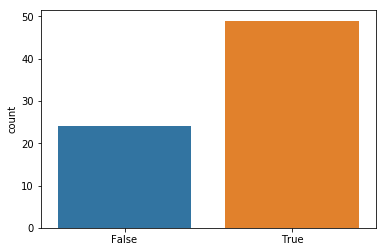

In [130]:
ax = sns.countplot(real_ups[predicted_ups])

In [131]:
pd.value_counts(real_ups[predicted_ups])

True     49
False    24
dtype: int64

In [136]:
model.save('SPY_model.hdf5')